In [16]:
%pip install --upgrade lightgbm

In [17]:
%pip install --upgrade scikit-learn

In [18]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [19]:
df = pd.read_csv('address_data_combined.csv')
df.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract),total ether received,total ether balance
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,0.040100,0.040100
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,2.650000,-0.284889
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,4.999916,0.000840
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,2.085000,0.000342


In [20]:
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(9908, 12)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract),total ether received,total ether balance
6709,17.06,0.00,51.17,1,101.0000,101.000000,101.000000,10.804780,33.666149,4,101.000000,0.001554
13808,2679.43,2841.02,275214.32,21,0.0001,15.000000,2.295850,0.000000,1.877316,100,103.313259,0.060902
8333,103299.49,37551.75,826452.87,6,0.0000,52.532971,23.290155,0.000000,16.627500,15,163.031084,30.011085
6981,4756.98,11283.84,46352.60,1,11.0000,20.000000,15.500000,9.975152,10.194942,7,31.000000,-19.974711
676,0.00,0.00,0.00,0,0.0000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000


In [21]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract)',
       'total ether received', 'total ether balance']

scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
  X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)
columns = X_train_full.columns

# Scaling
# only use training data to fit, to avoid data leakage
# Not required for Naive Bayes but performed to ensure all variables are standardized through all ML models
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "num_leaves": [20, 50, 100, 500, 1000],
    "max_depth": [i for i in range(3, 12)],
    "max_bin": [200, 300],
    "min_gain_to_split": [i for i in range(0, 15, 5)],
    "bagging_fraction": [0.2, 0.3, 0.5, 0.7, 0.95],
    "bagging_freq": [1],
    "feature_fraction": [0.2, 0.3, 0.5, 0.7, 0.95]
}


In [ ]:
clf = lgb.LGBMClassifier()

tuned_clf = GridSearchCV(estimator=clf,
                         param_grid=params,
                         scoring='f1',
                         cv=5,
                         verbose=0,
                         )

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#tuned_clf.fit(X_train_full,y_train_full, verbose = 0)

In [22]:
# lightgbm_params = {"bagging_fraction": 0.95,
#                    "bagging_freq": 1,
#                    "feature_fraction": 0.95,
#                    "learning_rate": 0.2,
#                    "max_bin": 300,
#                    "max_depth": 6,
#                    "min_gain_to_split": 0,
#                    "num_leaves": 20}

# lightgbm_params = {
#     "bagging_fraction": 0.95,
#     "bagging_freq": 1,
#     "feature_fraction": 0.95,
#     "learning_rate": 0.2,
#     "max_bin": 300,
#     "max_depth": 6,
#     "min_split_gain": 0,  # Use the official name here
#     "num_leaves": 20
# }
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarning


lightgbm_params = {
    "bagging_fraction": 0.95,
    "bagging_freq": 1,
    "feature_fraction": 0.95,
    "learning_rate": 0.2,
    "max_bin": 300,
    "max_depth": 6,
    "min_split_gain": 0,  # Use the official name here
    "num_leaves": 20,
    "colsample_bytree": None,  # Explicitly set to avoid conflict
    "subsample": None,  # Explicitly set to avoid conflict
    "subsample_freq": None  # Explicitly set to avoid conflict
}




lightgbm_model = lgb.LGBMClassifier(**lightgbm_params)
lightgbm_model.fit(X_train_full, y_train_full)

[LightGBM] [Info] Number of positive: 4562, number of negative: 5346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3460
[LightGBM] [Info] Number of data points in the train set: 9908, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460436 -> initscore=-0.158587
[LightGBM] [Info] Start training from score -0.158587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(bagging_fraction=0.95, bagging_freq=1, colsample_bytree=None,
               feature_fraction=0.95, learning_rate=0.2, max_bin=300,
               max_depth=6, min_split_gain=0, num_leaves=20, subsample=None,
               subsample_freq=None)

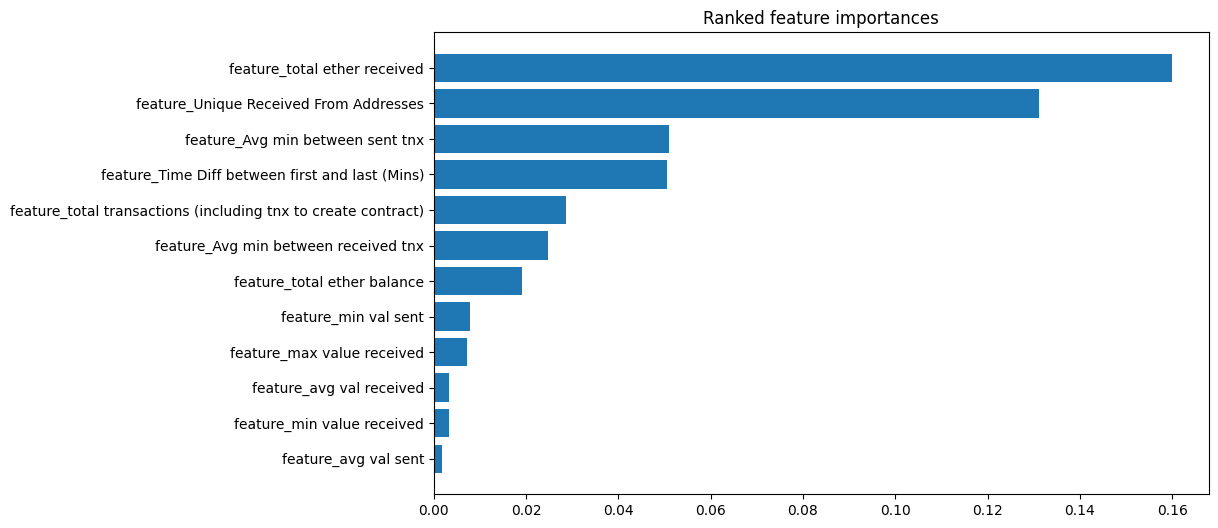

In [23]:
from sklearn.inspection import permutation_importance
feat_importances = permutation_importance(lightgbm_model, X_test, y_test)['importances_mean']
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [24]:
best_y_pr = lightgbm_model.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, best_y_pr))
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Accuracy Score:  0.9352484106428067
Test F1 Score:  0.9300788202390033


In [25]:
import joblib
joblib.dump(lightgbm_model, 'lightBGM_fraud_model_final_original.pkl')

['lightBGM_fraud_model_final_original.pkl']

In [26]:
from sklearn.pipeline import Pipeline
import joblib


# Create the pipeline
scaler_function = Pipeline([


    # Scaling step (using the pre-fitted scaler)
    ('scaler', scaler)  # Use the scaler already fitted on X_train_full
])

# Save the pipeline
joblib.dump(scaler_function, 'original_scaler.pkl')

['original_scaler.pkl']

In [32]:
import pandas as pd
import joblib
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def log_transform_df(X):
    X = X.copy()
    for col in X.columns:
        X[col] = X[col].apply(lambda x: np.log(x) if x > 0 else 0)
    return X


scaler = joblib.load('original_scaler.pkl')
model = joblib.load('lightBGM_fraud_model_final_original.pkl')

# Define a single transaction (example values)
df = pd.DataFrame({
    'Avg min between sent tnx': [6.0],
    'Avg min between received tnx': [8.33],
    'Time Diff between first and last (Mins)': [83247.35],
    'Unique Received From Addresses': [59],
    'min value received': [0.0],
    'max value received': [0.01],
    'avg val received': [0.000002],
    'min val sent': [0.0],
    'avg val sent': [0.0],
    'total transactions (including tnx to create contract)': [10000],
    'total ether received': [0.015],
    'total ether balance': [0.015]
}
)

# Preprocess and predict
df = log_transform_df(df)
npArray_processed = scaler.transform(df)
print(npArray_processed)
fraud_probability = model.predict_proba(npArray_processed)[:, 1][0]
print(f"Fraud Probability: {fraud_probability:.4f}")

[[0.24817845 0.37863452 0.79436804 0.44271781 0.81818182 0.27515136
  0.         0.60165538 0.59528645 0.93003327 0.26839648 0.26839648]]
Fraud Probability: 0.0170


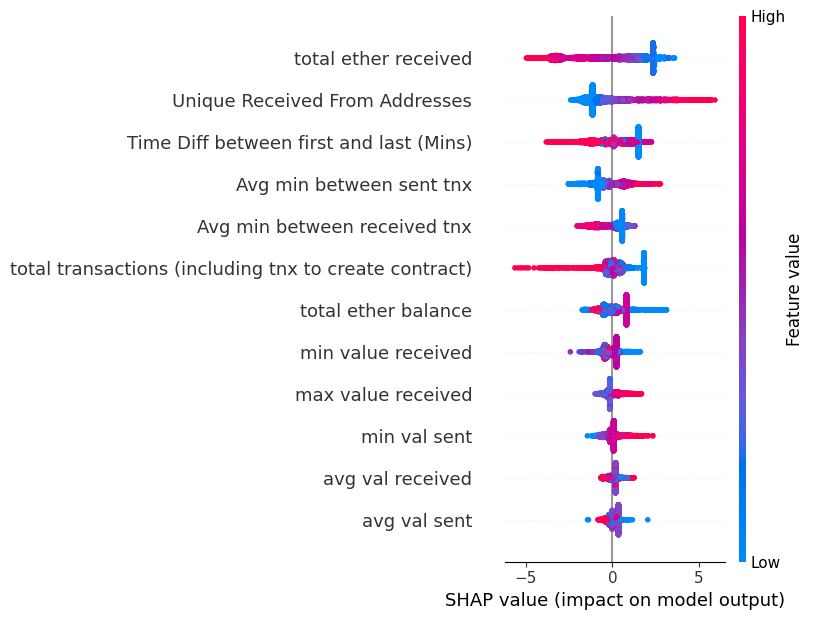

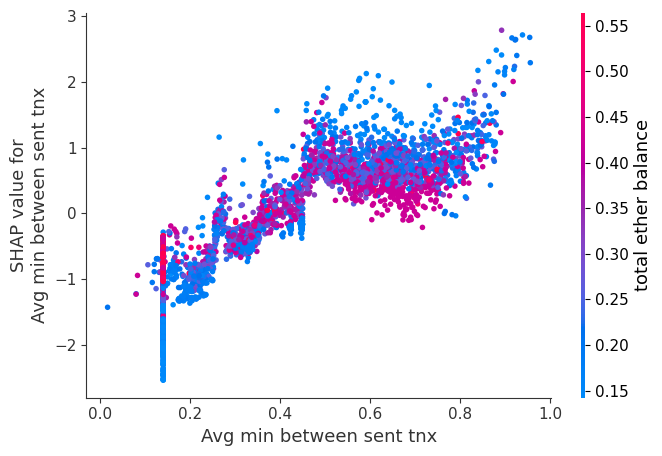

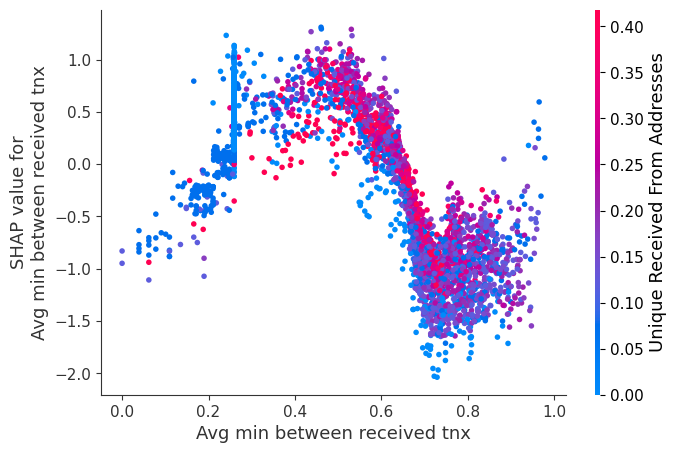

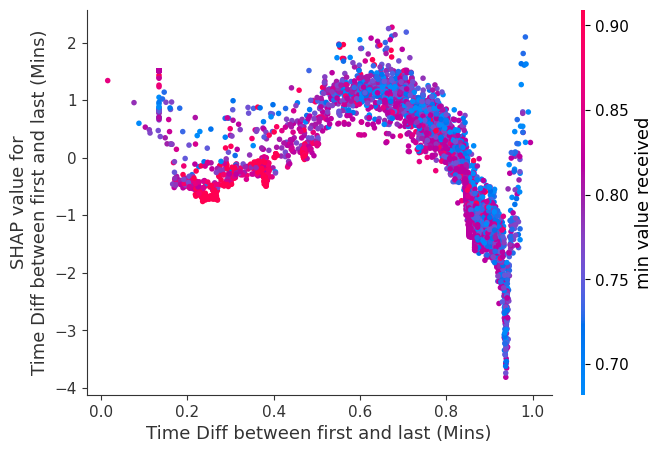

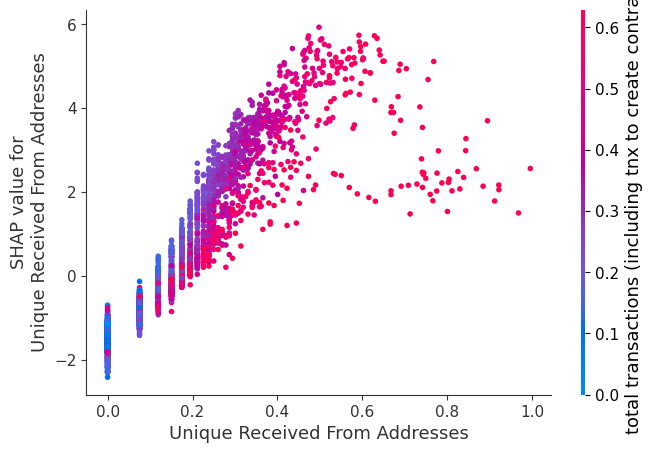

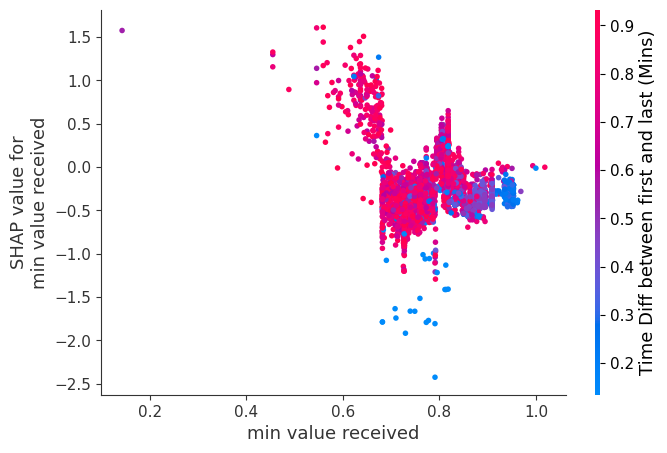

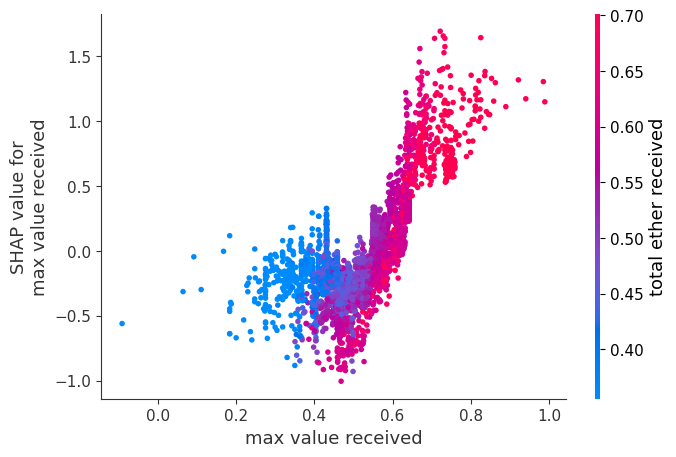

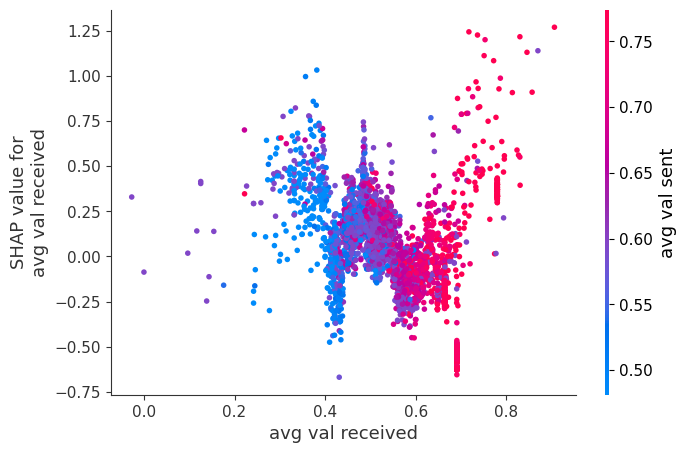

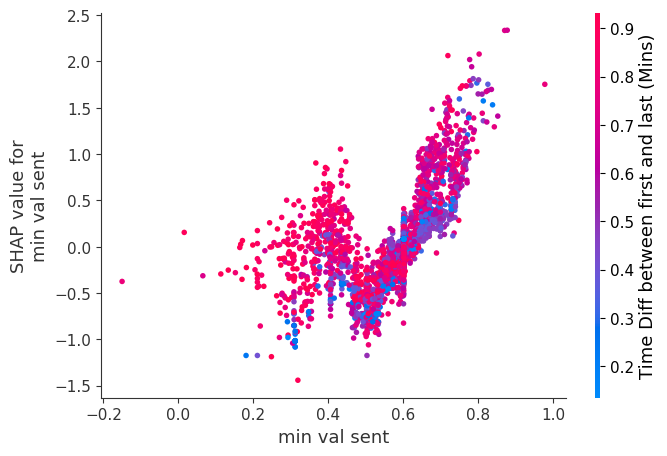

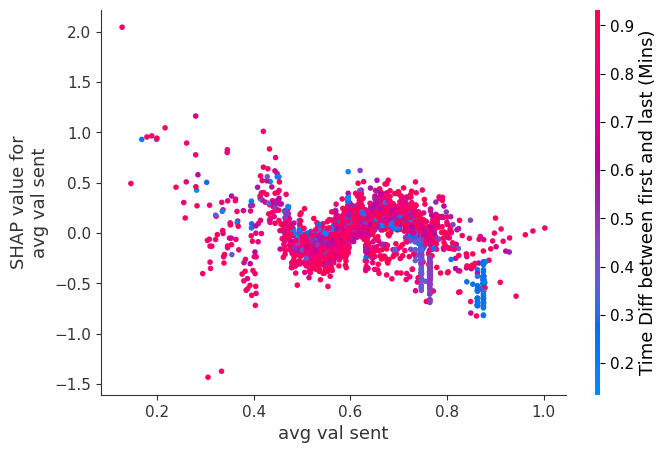

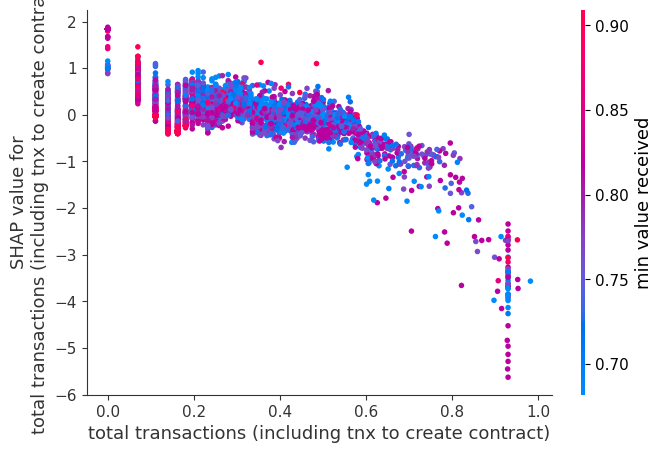

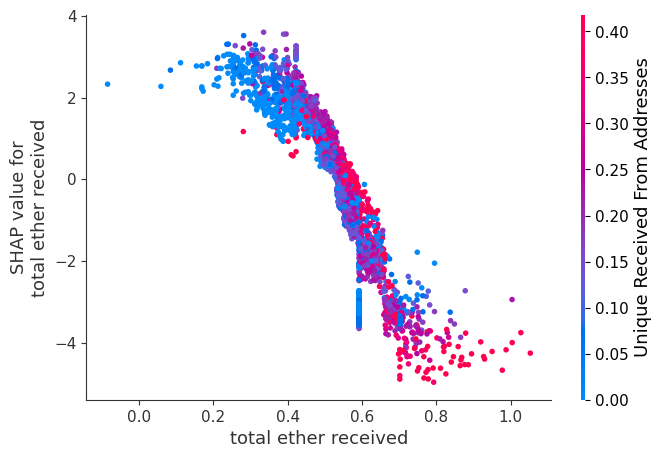

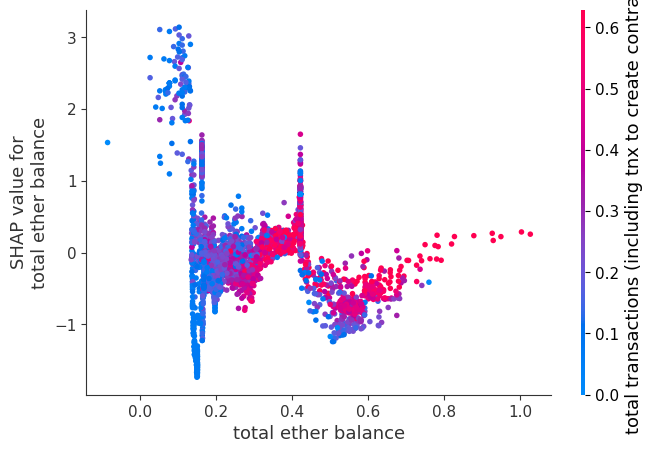

In [33]:
import shap
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Manually define feature names (MUST match training features)
feature_names = [
    "Avg min between sent tnx",
    "Avg min between received tnx",
    "Time Diff between first and last (Mins)",
    "Unique Received From Addresses",
    "min value received",
    "max value received",
    "avg val received",
    "min val sent",
    "avg val sent",
    "total transactions (including tnx to create contract)",
    "total ether received",
    "total ether balance"
]

# Convert X_test to DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=feature_names)


explainer = shap.Explainer(lightgbm_model)
shap_values = explainer(X_test_df)

# Summary Plot
shap.summary_plot(shap_values, X_test_df)

# Dependence Plots
for feature in feature_names:
    shap.dependence_plot(feature, shap_values.values, X_test_df)

# Force Plot for a Single Prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test_df.iloc[0])
